In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


In [3]:
import numpy as np
import pandas as pd
import os
import cv2
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import matplotlib.pyplot as plt

In [4]:
dir = r'C:\Users\jagan\OneDrive\Desktop\intership\Task4\extracted_files\leapGestRecog'  # Update this to your actual dataset path

In [5]:
images = []
labels = []
for directory in os.listdir(dir):
    for subDir in os.listdir(os.path.join(dir, directory)):
        for img in os.listdir(os.path.join(dir, directory, subDir)):
            img_path = os.path.join(dir, directory, subDir, img)
            images.append(img_path)
            labels.append(subDir)

In [6]:
# Converting the data to DataFrame
Iseries = pd.Series(images, name="Images")
Lseries = pd.Series(labels, name="labels")
hand_gesture_data = pd.concat([Iseries, Lseries], axis=1)
hand_gesture_df = pd.DataFrame(hand_gesture_data)
print(hand_gesture_df.head())


                                              Images   labels
0  C:\Users\jagan\OneDrive\Desktop\intership\Task...  01_palm
1  C:\Users\jagan\OneDrive\Desktop\intership\Task...  01_palm
2  C:\Users\jagan\OneDrive\Desktop\intership\Task...  01_palm
3  C:\Users\jagan\OneDrive\Desktop\intership\Task...  01_palm
4  C:\Users\jagan\OneDrive\Desktop\intership\Task...  01_palm


In [7]:
# Counting the images in each class
print(pd.Series(labels).value_counts())

01_palm          2000
02_l             2000
03_fist          2000
04_fist_moved    2000
05_thumb         2000
06_index         2000
07_ok            2000
08_palm_moved    2000
09_c             2000
10_down          2000
00                  9
Name: count, dtype: int64


In [8]:
for img_path in hand_gesture_df["Images"]:
    if not os.path.exists(img_path):
        print(f"Invalid image path: {img_path}")


In [9]:
# Remove rows with invalid image paths
hand_gesture_df = hand_gesture_df[hand_gesture_df["Images"].apply(lambda x: os.path.exists(x))]


In [10]:
def is_valid_image(file_path):
    try:
        img = cv2.imread(file_path)
        return img is not None
    except Exception as e:
        return False

# Filter out invalid image files
hand_gesture_df = hand_gesture_df[hand_gesture_df["Images"].apply(is_valid_image)]


In [11]:
print(hand_gesture_df['labels'].value_counts())


labels
01_palm          2000
02_l             2000
03_fist          2000
04_fist_moved    2000
05_thumb         2000
06_index         2000
07_ok            2000
08_palm_moved    2000
09_c             2000
10_down          2000
Name: count, dtype: int64


In [12]:
# Splitting the dataset into train and test
X_train, X_test = train_test_split(hand_gesture_df, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(hand_gesture_df, test_size=0.3, random_state=42)

# Data Preprocessing
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe=train_set, x_col="Images", y_col="labels",
                                       target_size=(244, 244),
                                       color_mode='rgb',
                                       class_mode="categorical",
                                       batch_size=4,
                                       shuffle=False)

test = image_gen.flow_from_dataframe(dataframe=X_test, x_col="Images", y_col="labels",
                                      target_size=(244, 244),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=4,
                                      shuffle=False)

val = image_gen.flow_from_dataframe(dataframe=val_set, x_col="Images", y_col="labels",
                                     target_size=(244, 244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle=False)

classes = list(train.class_indices.keys())
print(classes)

Found 14000 validated image filenames belonging to 10 classes.
Found 4000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.
['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


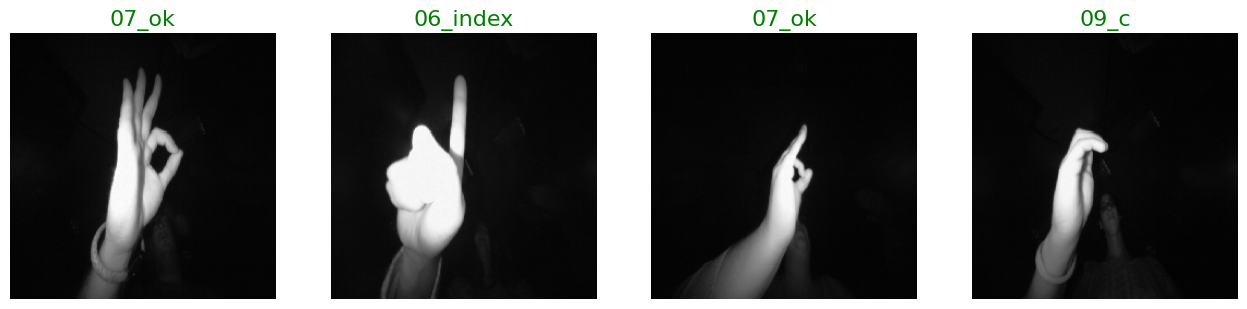

In [13]:
# Data visualization function
def show_hand_gesture(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels = next(image_gen)
    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = min(length, 25)
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = (images[i] + 1) / 2
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color="green", fontsize=16)
        plt.axis('off')
    plt.show()

show_hand_gesture(train)

In [14]:
from tensorflow.keras import layers, models

# Building your model
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),  # Use Input layer for input shape
    layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3, 3)),
    layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 73, 73, 128)         │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 73, 73, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 73, 73, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 73, 73, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 24, 24, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 12, 12, 512)         │           2,0

 Total params: 15,617,674 (59.58 MB)

 Trainable params: 15,611,274 (59.55 MB)

 Non-trainable params: 6,400 (25.00 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [16]:
# Training your model
history = model.fit(train, epochs=1, validation_data=val, verbose=1)



C:\Users\jagan\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3500/3500 ━━━━━━━━━━━━━━━━━━━━ 1481s 423ms/step - accuracy: 0.6296 - loss: 1.2730 - val_accuracy: 0.9960 - val_loss: 0.0149


In [23]:
# Testing your model
model.evaluate(test, verbose=1)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 108s 108ms/step - accuracy: 0.9968 - loss: 0.0133


[0.012784015387296677, 0.9972500205039978]

In [31]:
# Saving your model
model.save("hand_gesture_Model.keras")


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 106s 105ms/step


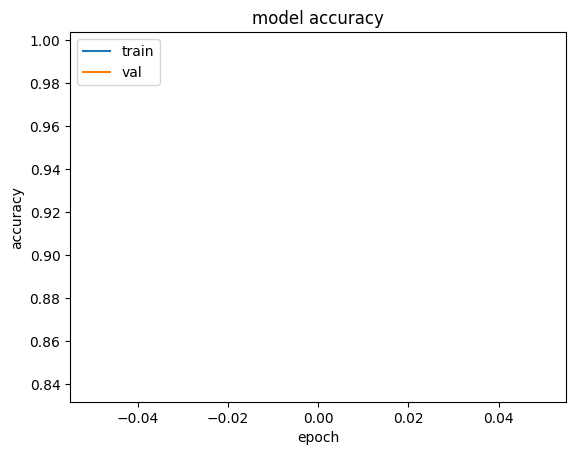

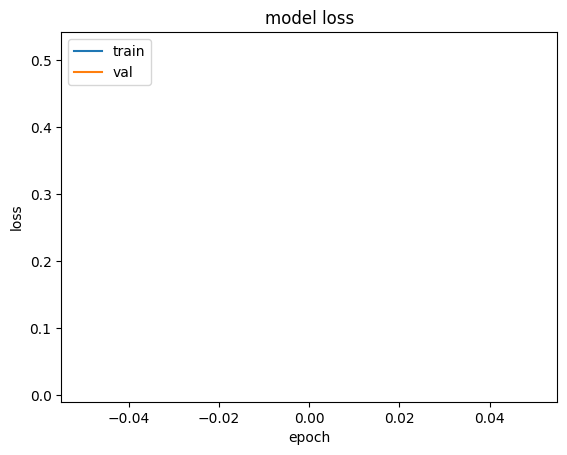

               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       417
         02_l       1.00      1.00      1.00       404
      03_fist       1.00      0.99      0.99       404
04_fist_moved       1.00      1.00      1.00       418
     05_thumb       0.98      1.00      0.99       377
     06_index       1.00      0.99      0.99       392
        07_ok       1.00      1.00      1.00       403
08_palm_moved       0.99      1.00      1.00       409
         09_c       1.00      1.00      1.00       410
      10_down       1.00      1.00      1.00       366

     accuracy                           1.00      4000
    macro avg       1.00      1.00      1.00      4000
 weighted avg       1.00      1.00      1.00      4000

Accuracy of the Model: 99.7%


In [30]:
# Getting results
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

labels = (train.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred2 = [labels[k] for k in pred]

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

y_test = X_test.labels

print(classification_report(y_test, pred2))
print("Accuracy of the Model:", "{:.1f}%".format(accuracy_score(y_test, pred2) * 100))